In [1]:
import os
import sys
sys.path.insert(0, "../")

import numpy as np
import matplotlib.pyplot as plt
from beam.beams import laserpulse
from beam.elements import plasma
from beam import interactions
import warnings

In [2]:
# Define ionization info for a couple different species
H = {'EI': 13.5984,
     'Z': 1,
     'l': 0,
     'm': 0,
     'alpha': 0.667}
H2 = {'EI': 15.426,
      'Z': 1,
      'l': 0,
      'm': 0,
      'alpha': 0.787}
He = {'EI': 24.5874,
      'Z': 1,
      'l': 0,
      'm': 0,
      'alpha': 0.208}
Ar = {'EI': 15.7596,
      'Z': 1,
      'l': 1,
      'm': 0,
      'alpha': 1.664}
Li = {'EI': 5.3917,
      'Z': 1,
      'l': 0,
      'm': 0,
      'alpha': 24.33}

Initial pulse energy: 10.00mJ


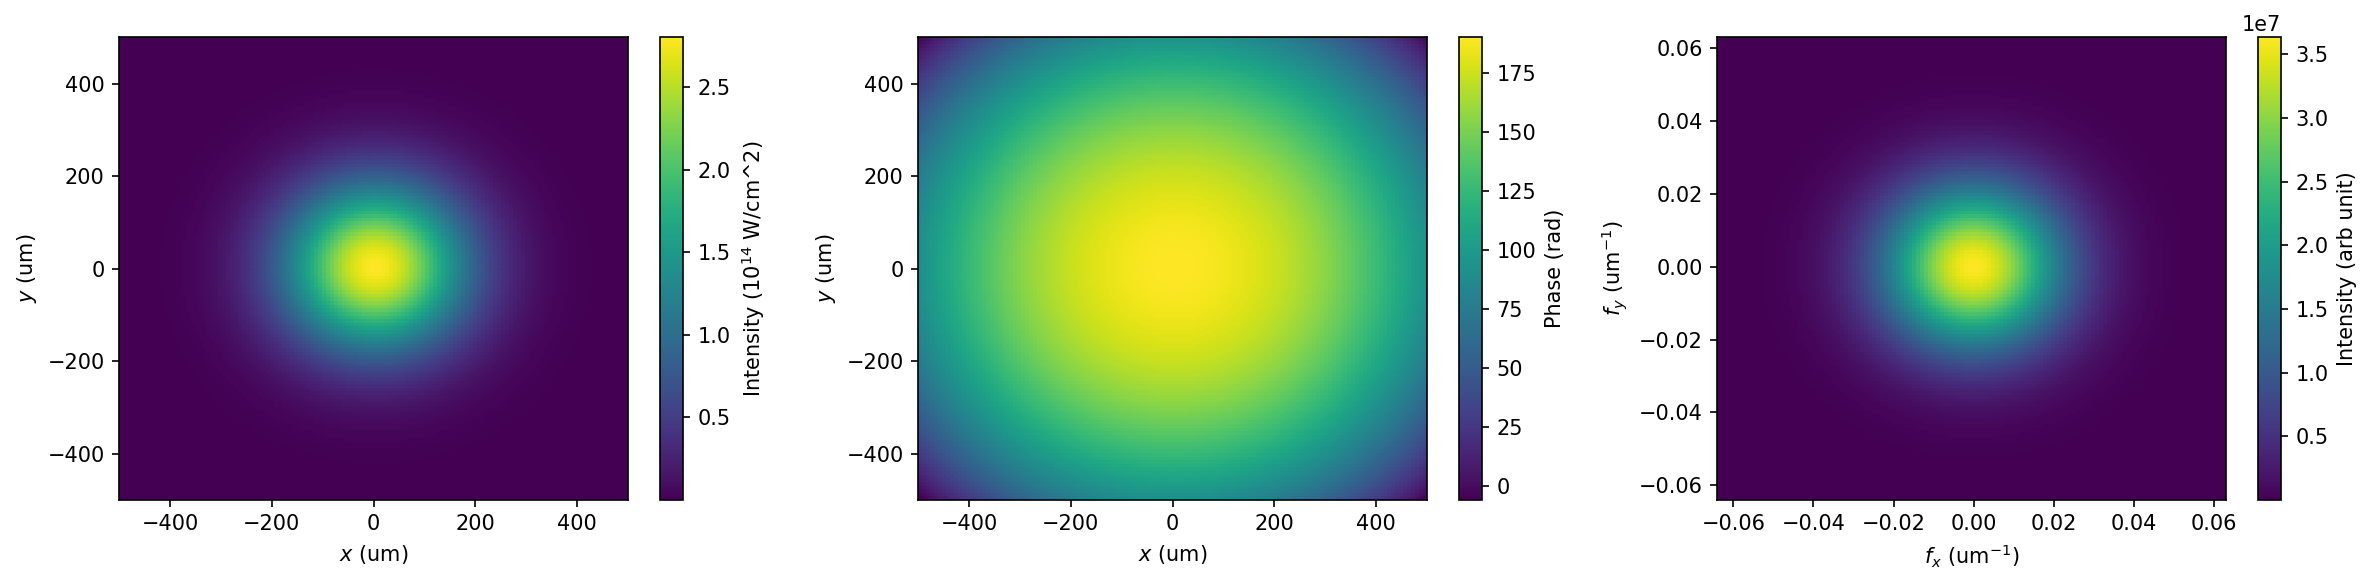

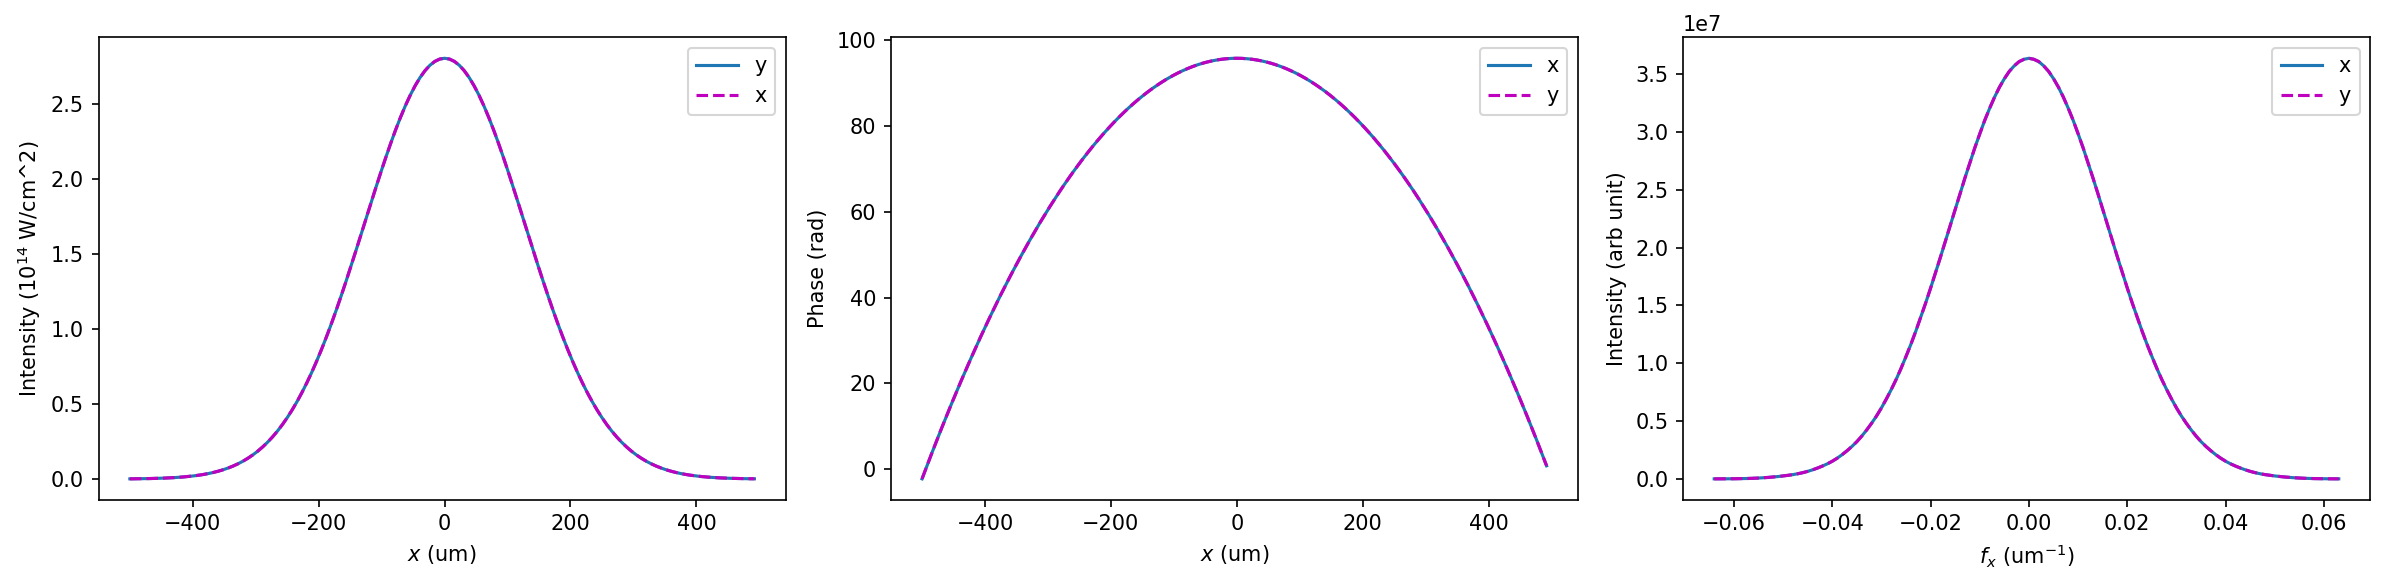

In [3]:
# The pulse exists in 3 dimensions: x and y are transverse dimensions, t is the longitudinal dimension comoving with the pulse
# The beam info in all 3 dimensions is tracked as a function of the propagation distance z
# The simulation framework is setup to let the laser pulse interact with multiple elements
# In this example the laser pulse interacts with a single element, a gas cell that can be ionized
# The gas cell can be initialized with different initial gas densities and plasma densities
# The plasma/gas density is tracked in x, y, z. x and y must match the pulse grid. z determines the propagation step size

# Setup the grid and initialize the pulse object and the gas/plasma object
# ----------------------------------------------------------------------------------------------------------------------
path = 'data/'  # Path to the directory to save data in
lam = 0.8      # Laser wavelength um
tau = 35       # Pulse length, sigma_t for a Gaussian pulse, fs
Nx = 2**8      # Number of cells in the x direction, powers of two are faster for the fft
Ny = 2**8      # Number of cells in the y direction, powers of two are faster for the fft
X = 1e3        # Size of the simulation domain in the x direction, um
Y = 1e3        # Size of the simulation domain in the y direction, um
N = 280        # Number of longitudinal cells in the plasma
Z = 2e4        # Length of the plasma, um
energy = 10e-3 # Pulse energy, J
w0 = 10        # Waist size, um

E0 = 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9 # Peak electric field at the waist, GV/m
z = np.linspace(0, Z, N) # You can create a z grid with non-uniform cell sizes if you want

pulseParams = {
    'Nx' : Nx,
    'Ny' : Ny,
    'Nt' : 2**6,      # Number of cells in t
    'X' : X,
    'Y' : Y,
    'T' : 3*tau,      # Temporal extent of the simulation box
    'lam' : lam,
    'path' : path,
    'name' : 'Pulse', # Used to name the results files
    'load' : False,   # Set to true to load a previously run simulation
    'threads' : 4,    # Number of threads to run on - set equal to the number of processors on your computer
    'cyl' : True,     # Setting to true only saves simulation results in the x-t plane
    # Everything above is always required for a laser pulse
    # Everything below is specific to the Gaussian laser pulse
    'tau' : tau,
    'z0' : -1e4,      # Distance from the waist to initialize the pulse at, only used for Gaussian pulse
    'E0' : E0,
    'waist' : w0
}
plasmaParams = {
    'Nx' : Nx,
    'Ny' : Ny,
    'Nz' : N,
    'X' : X,
    'Y' : Y,
    'Z' : Z,
    'atom' : He,       # Species to ionize
    'path' : path,
    'name' : 'Plasma', # Used to name the results files
    'load' : False,    # Set to true to load a previously run simulation
    'cyl' : True,      # Setting to true only saves simulation results in the x-z plane
    'n0' : 5e17/1e17   # Gas number density in 10^17 particles/cm^3
}

pulse = laserpulse.GaussianPulse(pulseParams)
helium = plasma.UniformPlasma(plasmaParams)

# Show the initial laser pulse and calculate the energy
# ----------------------------------------------------------------------------------------------------------------------
# Built in function to calculate the pulse energy
print("Initial pulse energy: %0.2fmJ" % (pulse.pulse_energy()*1e3))
# Built in function to check real space and Fourier space to make sure the grid resolves the beam
# The function plots the t=0 slice of the pulse
pulse.plot_current_field()

In [4]:
# Run the simulation
# ----------------------------------------------------------------------------------------------------------------------
interactions.pulse_plasma(pulse, helium)

Final pulse energy: 10.00mJ


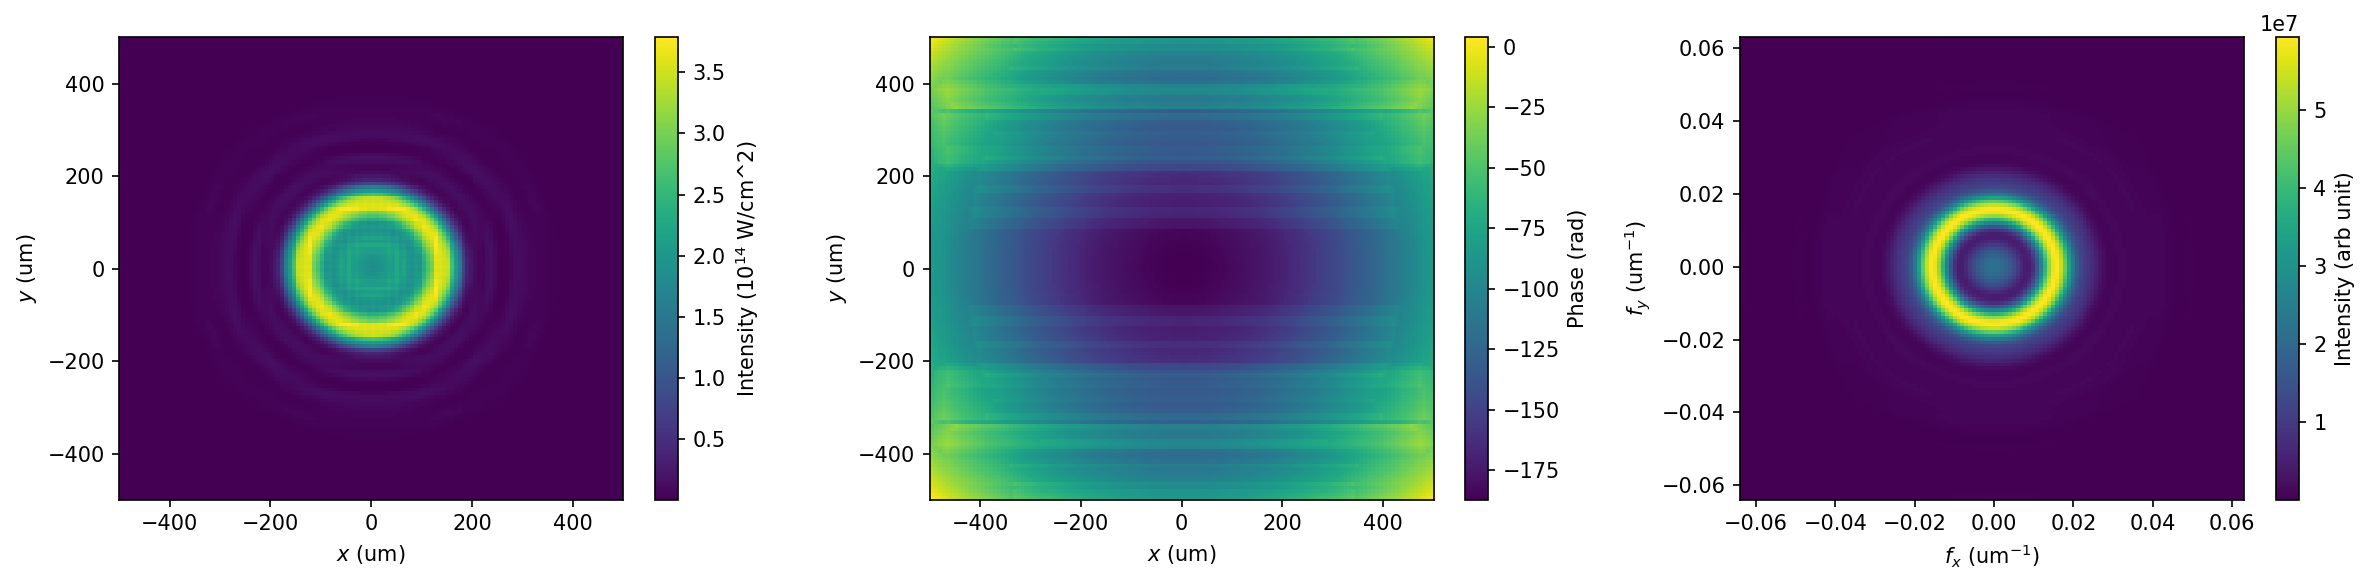

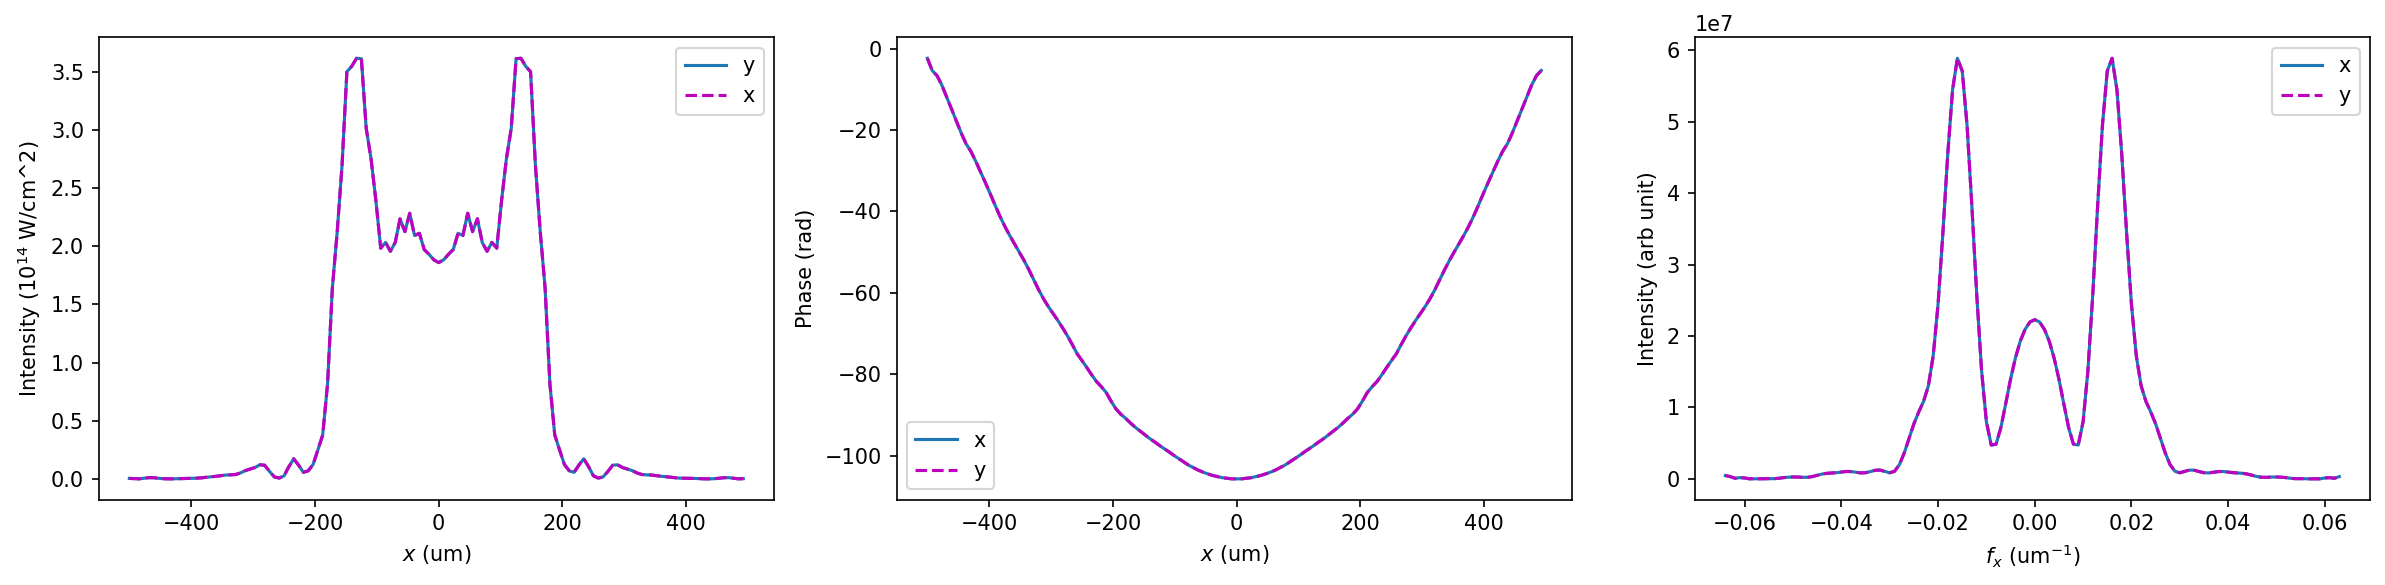

In [5]:
# Plot the results
# ----------------------------------------------------------------------------------------------------------------------
# The final pulse energy can be extracted , the basic simulation doesn't include energy loss
# Sometimes the 2D phase unwrapping doesn't work very well, but the lineouts normally do
print("Final pulse energy: %0.2fmJ" % (pulse.pulse_energy()*1e3))
pulse.plot_current_field()

In [6]:
# You can also load the data from file to look at z slices further back in the simulation
def load_data():
    e = np.zeros((N, Nx), dtype='complex128')
    ne = np.zeros((N, Nx))
    for i in range(0, N-1):
        ne[i, :] = helium.load_plasma_density(i)[0]
    for i in range(N):
        e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
    I = pulse.intensity_from_field(e)
    ne = ne*1e17 # Convert to particles/cm^3
    return I, ne
I, ne = load_data()

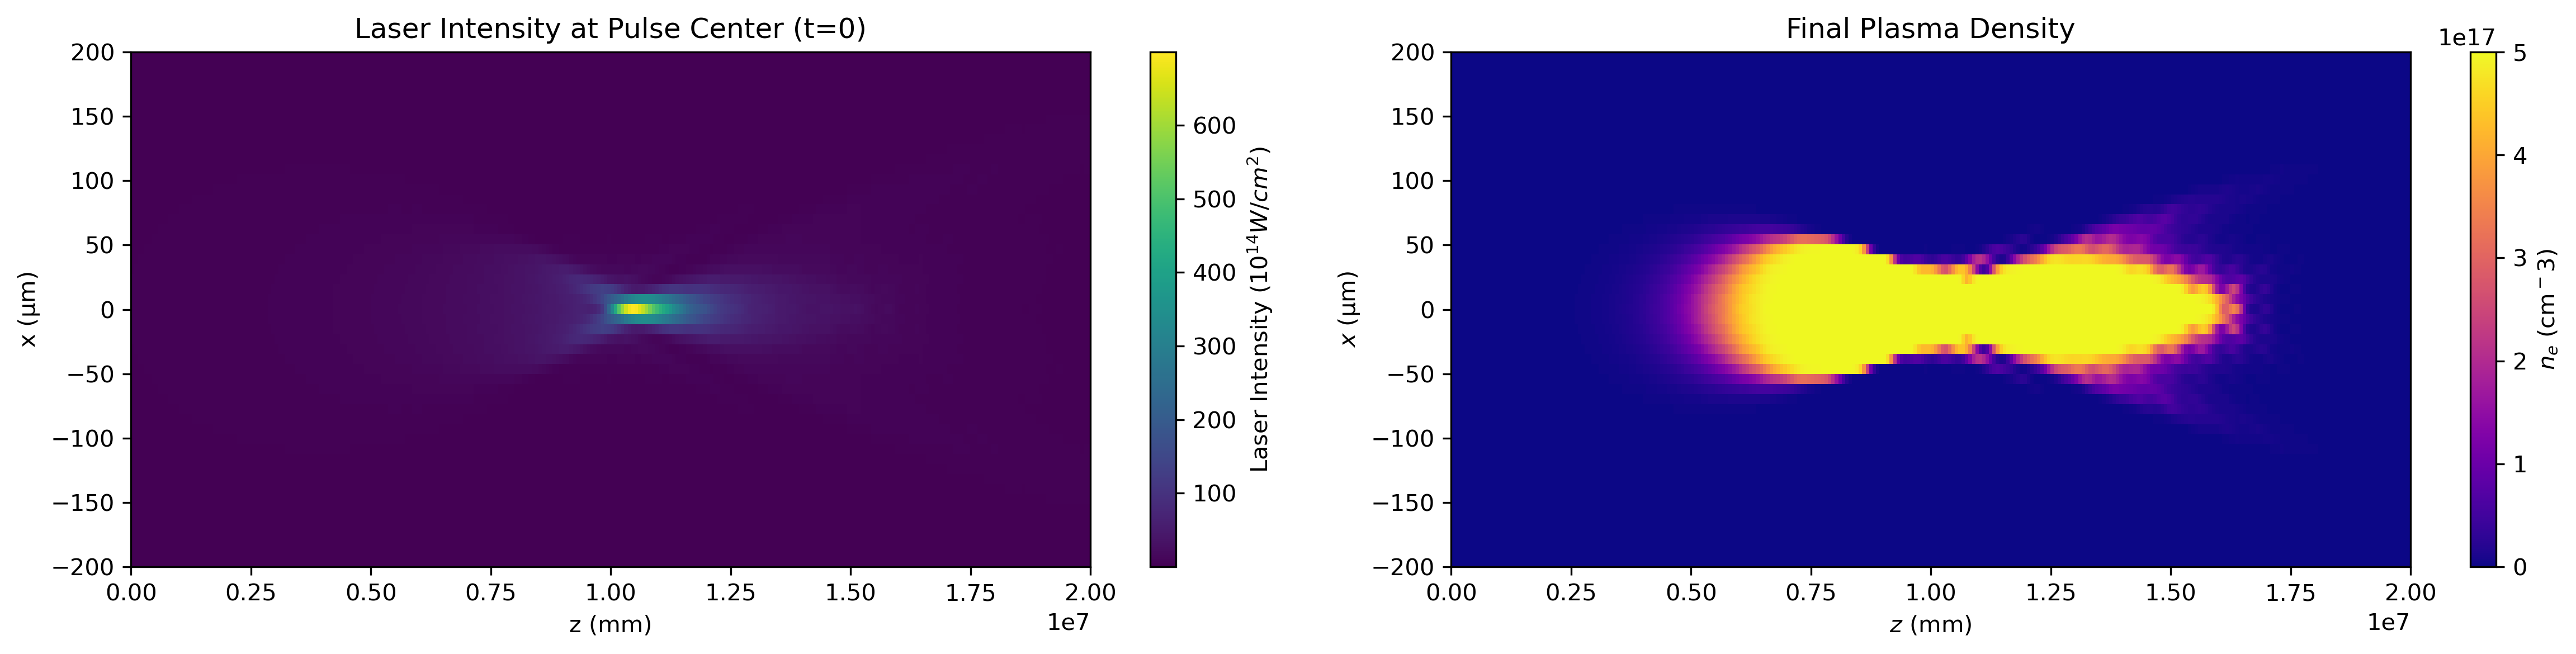

In [7]:
def plot_plasma(I, ne):
    ext = [z[0]*1e3, z[-1]*1e3, pulse.x[0], pulse.x[-1]]   

    plt.figure(figsize=(16, 4), dpi=300)
    plt.subplot(121)
    plt.imshow(pulse.prep_data(I), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (mm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)
    plt.title("Laser Intensity at Pulse Center (t=0)")

    plt.subplot(122)
    plt.imshow(pulse.prep_data(ne), aspect='auto', extent=ext, cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
    plt.xlabel('$z$ (mm)')
    plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)
    plt.title("Final Plasma Density")
    plt.tight_layout()

    plt.show()
plot_plasma(I, ne)

In [8]:
# Repeat the simulation with energy loss and Kerr effect
# ----------------------------------------------------------------------------------------------------------------------
# Kerr effect can be included, typically small effect and can be ignored
# Energy loss can be included, default only uses ionization energy
# Can specify an additional heating energy loss, maybe based off a PIC simulations
# Energy loss occurs locally rather than redshifting - better than nothing

pulse = laserpulse.GaussianPulse(pulseParams)
helium = plasma.UniformPlasma(plasmaParams)

print("Initial pulse energy: %0.2fmJ" % (pulse.pulse_energy()*1e3))
# I don't know what the second order index of refraction of helium gas is, I used the value for Hydrogen
# Temp sets an average heating energy in eV, here I assume the plasma has a temperature of 2eV
interactions.pulse_plasma_energy(pulse, helium, temp=2.0, n2=5.36e-19)
print("Final pulse energy: %0.2fmJ" % (pulse.pulse_energy()*1e3))

Initial pulse energy: 10.00mJ
Final pulse energy: 9.86mJ


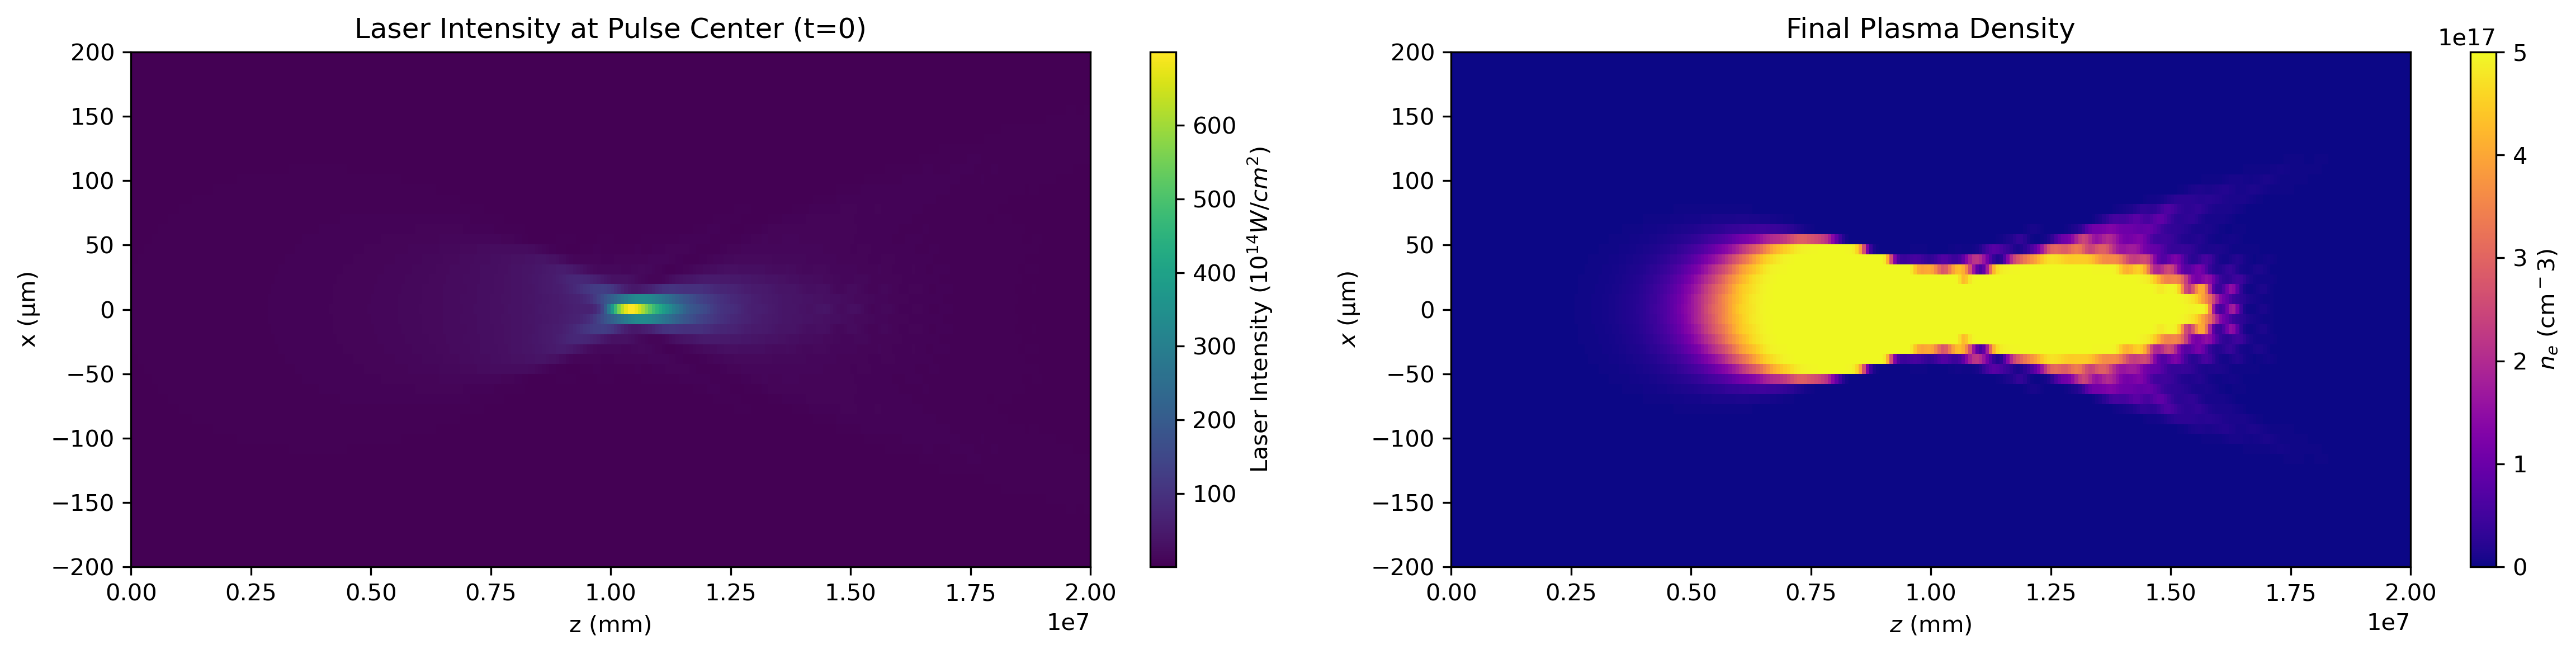

In [9]:
I, ne = load_data()
plot_plasma(I, ne)

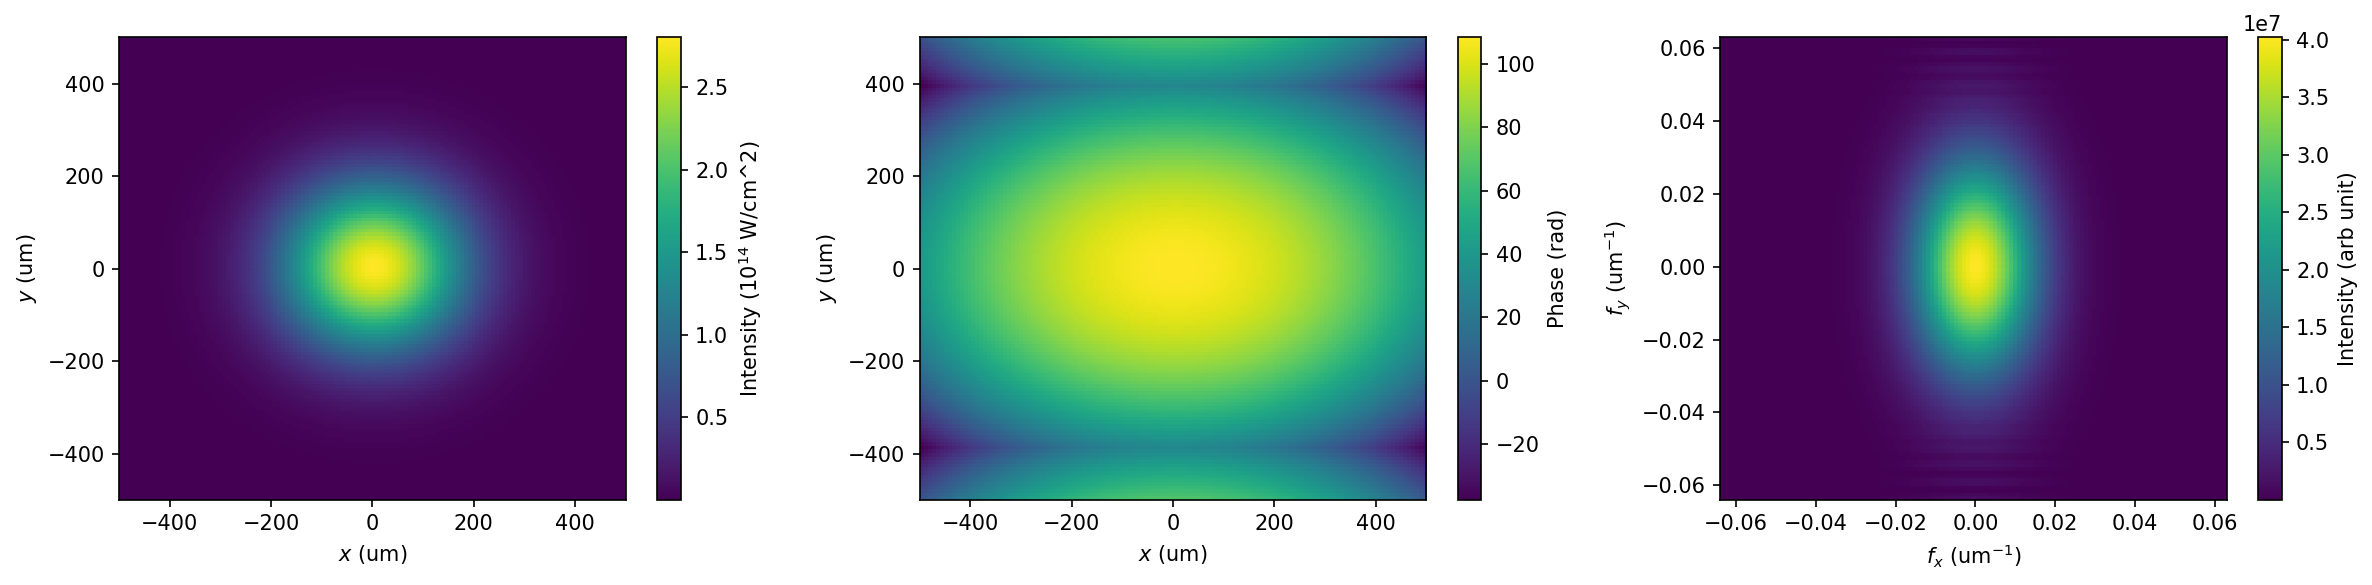

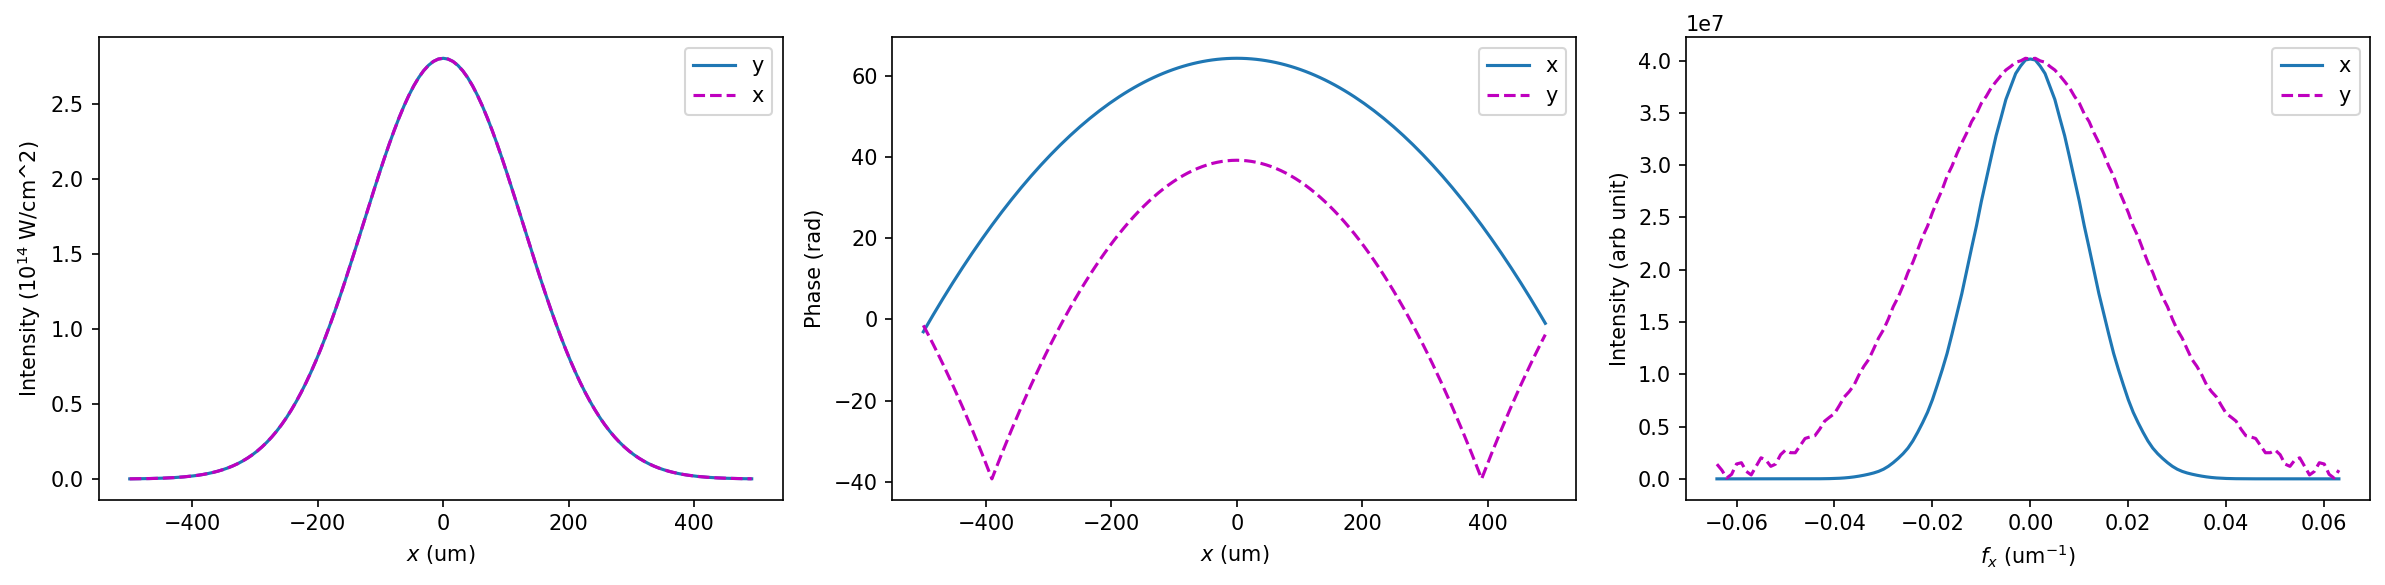

In [27]:
# You can directly set the electric field in the base class by calling initialize_field
# Here I add some aberration to the laser to see how it effects the ionization
# First grab the nice Gaussian field from the previous simulation
pulse = laserpulse.GaussianPulse(pulseParams)
e = pulse.e
pulse = laserpulse.Pulse(pulseParams)

# Calculate the phase for an astigmatism
rho2 = pulse.x[:, None]**2 + pulse.y[None, :]**2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    theta = np.arctan(pulse.y[None, :]/pulse.x[:, None])
theta[int(Nx/2), int(Nx/2)] = 0
rho2 = pulse.x[:, None]**2 + pulse.y[None, :]**2
phi = 0.005*np.sqrt(6)*rho2*np.cos(2*theta)/w0**2

# Add the astigmatism to the Gaussian intensity and initialize the field in the class
e = e*np.exp(1j*phi)
pulse.initialize_field(e)
pulse.plot_current_field()
# You can also set an initial gas density and plasma, say if the laser is being fired into a gas jet
# Set initial plasma density to zero and the longitudinal gas density to a Gaussian
ne = np.zeros((Nx, Nx, N), dtype='double')
n0 = 5e17       # Maximum gas density
sigma_z = 0.5e3 # In um
n = np.ones((Nx, Ny), dtype='double')[:, :, None]*n0*np.exp(-(z-Z/2)**2/(2*sigma_z**2))[None, None, :]
helium = plasma.Plasma(plasmaParams)
helium.initialize_plasma(n/1e17, ne)

In [28]:
print("Initial pulse energy: %0.2fmJ" % (pulse.pulse_energy()*1e3))
interactions.pulse_plasma_energy(pulse, helium, temp=2.0, n2=5.36e-19)
print("Final pulse energy: %0.2fmJ" % (pulse.pulse_energy()*1e3))

Initial pulse energy: 10.00mJ
Final pulse energy: 9.98mJ


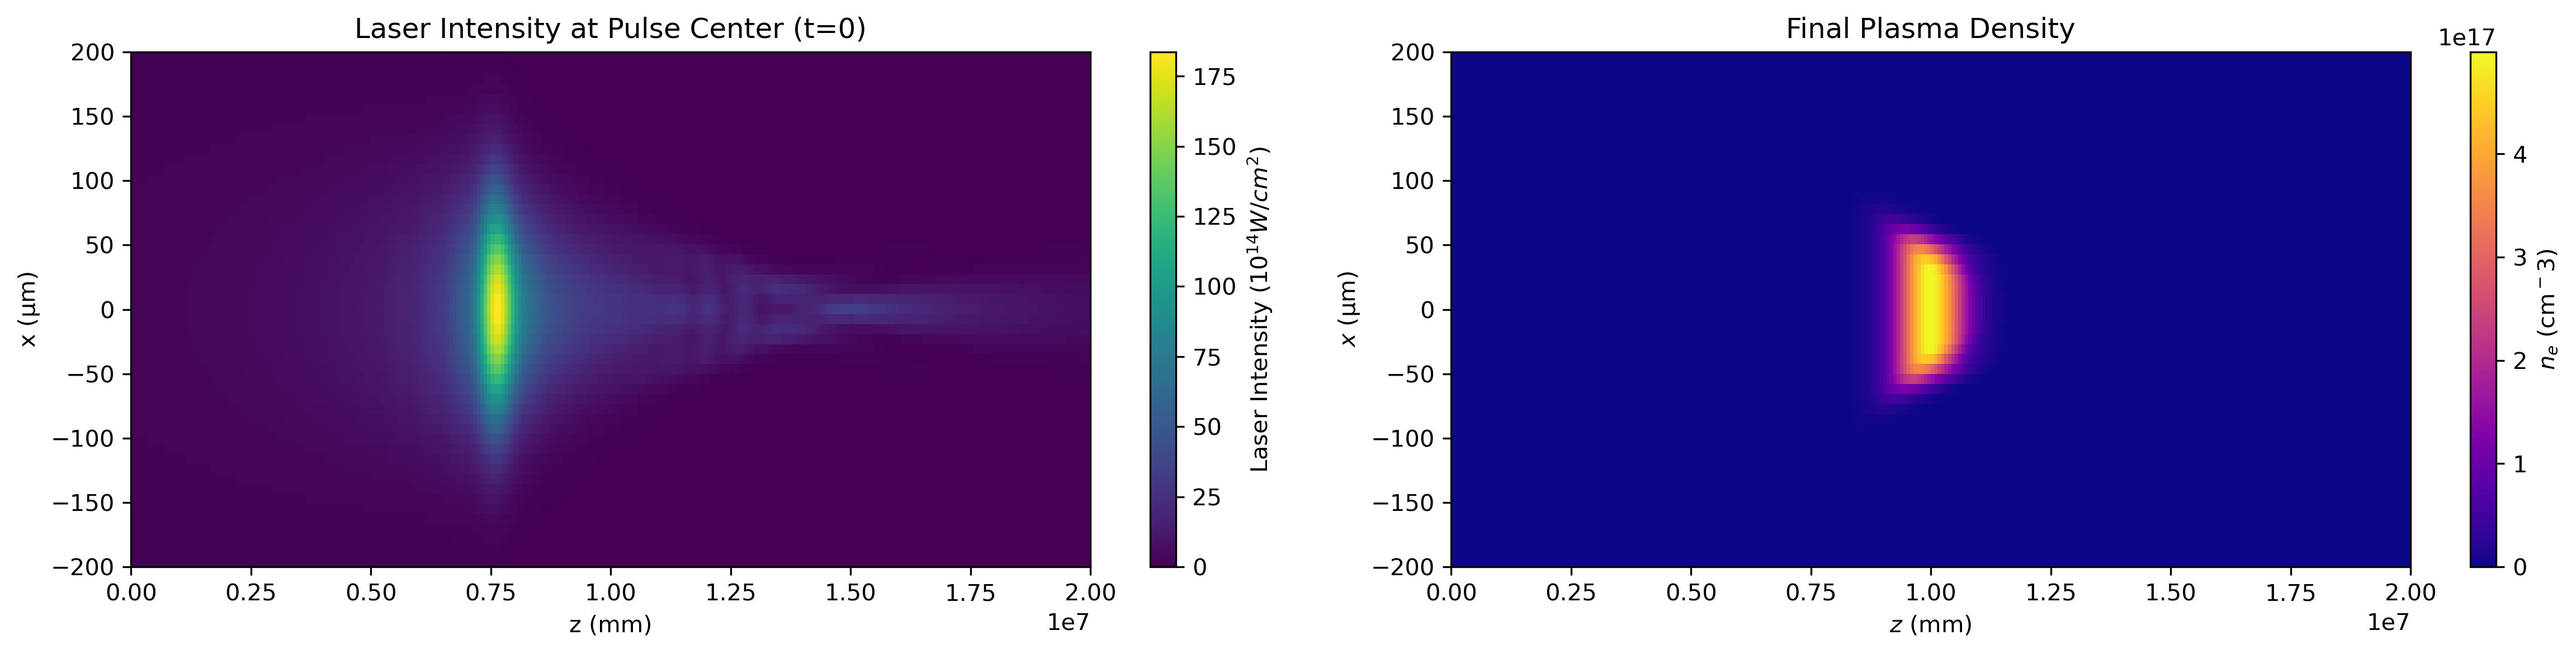

In [29]:
I, ne = load_data()
plot_plasma(I, ne)